In [1]:
from importlib.metadata import version

pkgs = ['numpy', 'matplotlib', 'tiktoken', 'torch']
for p in pkgs:
    print(f"{p} version: {version(p)}")

!which python; python --version

numpy version: 2.2.4
matplotlib version: 3.10.1
tiktoken version: 0.9.0
torch version: 2.6.0
/mnt/lustre/work/bethge/mwe102/.conda/llm/bin/python
Python 3.10.16


In [2]:
import os
import sys
import yaml
import math
import time
import random
import inspect
import argparse
from datetime import datetime
from dataclasses import dataclass

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import torch
import tiktoken
import torch.nn as nn
import torch.nn.functional as F

In [3]:
from dataloader import FineWebEduDataLoader
from hellaswag import render_example, iterate_examples, get_most_likely_row

run_id = datetime.now().strftime("%Y%m%d")
print(f'run id: {run_id}')

run id: 20250623


## Some utility functions
- estimate loss on a dataloader
- generate and sample from the model

In [4]:
# model loss estimation and sampling code
def calc_loss_loader(data_loader, model, device, num_batches, print_loss=True) -> float:
    model.eval()
    data_loader.reset()

    with torch.no_grad():
        loss_accum = 0.0
        loss_steps = num_batches
        for _ in range(loss_steps):
            x, y = data_loader.next_batch()
            x, y = x.to(device), y.to(device)
            with torch.autocast(device_type=device, dtype=torch.bfloat16):
                logits, loss = model(x, y)
            loss = loss / loss_steps
            loss_accum += loss.detach()
    
    if print_loss:
        # averaged per-step loss, averaged over `num_batches` batches or steps
        print(f"Validation loss: {loss_accum.item():.4f}")
    
    model.train()
    return loss_accum.item()


# caution: this is not distributed, so it will only work on a single gpu
def calc_hella_accuracy(model, device, print_acc=True) -> float:
    num_correct_norm = 0
    num_total = 0

    for i, example in enumerate(iterate_examples("val")):
        _, tokens, mask, label = render_example(example)
        tokens = tokens.to(device)
        mask = mask.to(device)
        # get the logits
        with torch.no_grad():
            with torch.autocast(device_type=device, dtype=torch.bfloat16):
                logits, loss = model(tokens)
            pred_norm = get_most_likely_row(tokens, mask, logits)
        num_total += 1
        num_correct_norm += int(pred_norm == label)
    
    acc_norm = num_correct_norm / num_total
    if print_acc:
        print(f"HellaSwag accuracy: {num_correct_norm}/{num_total}={acc_norm:.4f}")
    return acc_norm


# caution: this is not distributed, so it will only work on a single gpu
def generate_and_print_samples(model, tokenizer, device,
                               num_return_sequences = 4,
                               max_length = 32,
                               start_context = "Hello, I'm a language model,",
                               random_seed = 42
                               ):
    
    model.eval()
    encoder = None
    decoder = None
    if hasattr(tokenizer, 'encode'):
        encoder = tokenizer.encode
        decoder = tokenizer.decode
    elif hasattr(tokenizer, 'tokenize'):
        encoder = tokenizer.tokenize
        decoder = tokenizer.detokenize
    else:
        raise ValueError(f"Please pass a tokenizer with either encode/decode or tokenize/detokenize methods")

    
    tokens = encoder(start_context)
    tokens = torch.tensor(tokens, dtype=torch.long)
    tokens = tokens.unsqueeze(0).repeat(num_return_sequences, 1)
    xgen = tokens.to(device)
    # don't interfere with other seeds
    sample_rng = torch.Generator(device=device)
    sample_rng.manual_seed(random_seed)

    while xgen.size(1) < max_length:
        # forward the model to get the logits
        with torch.no_grad():
            with torch.autocast(device_type=device, dtype=torch.bfloat16):
                logits, loss = model(xgen) # (B, T, vocab_size)
            # take the logits at the last position
            # print(logits.shape, logits.dtype)
            logits = logits[:, -1, :] # (B, vocab_size)
            # get the probabilities
            probs = F.softmax(logits, dim=-1)
            # do top-k sampling of 50 (huggingface pipeline default)
            # topk_probs here becomes (5, 50), topk_indices is (5, 50)
            topk_probs, topk_indices = torch.topk(probs, 50, dim=-1)
            # select a token from the top-k probabilities
            # note: multinomial does not demand the input to sum to 1
            ix = torch.multinomial(topk_probs, 1, generator=sample_rng) # (B, 1)
            # gather the corresponding indices
            xcol = torch.gather(topk_indices, -1, ix) # (B, 1)
            # append to the sequence
            xgen = torch.cat((xgen, xcol), dim=1)
    # print the generated text
    for i in range(num_return_sequences):
        tokens = xgen[i, :max_length].tolist()
        decoded = decoder(tokens)
        print(f"sample {i}: {decoded}")
    
    model.train()

## Hyperparameters

In [5]:
@dataclass
class Args:
    # config
    model_size = '150M'
    sparse_value_frac = None # None for vanilla

    # data
    data_root='./edu_fineweb10B'

    # batch size and gradient accumulation
    total_batch_size = 524_288 # 2**19, closest power of 2 to ~0.5M
    B = 32    # 8 fits for 900M, 16 fits for 450M, 32 fits in one A100 40GB for 150M model
    T = 1024
    vocab_size = 50304
    use_compile = True
    
    # optimization
    max_lr = 6e-4 # prev constant lr that we were using
    min_lr = max_lr * 0.1
    warmup_steps = 2000 # to be consistent with the tokenformer paper
    max_steps =  19_073 # 19,073 steps is ~1 epoch, if data is 10B tokens and batch size 0.5M tokens

    # iters to estimate val loss
    val_loss_steps = 20

    # evaluation and logging
    val_loss_every = 250 # every how many steps to evaluate val loss? 0 for only at the end
    sample_from_model_every = 250
    save_checkpoint_every = 2500
    logs_dir = './logs'
    checkpoint_dir = './checkpoints'
    save_checkpoint = False

args = Args()

### learning rate scheduler
- max lr: 6e-4
- warmup of 2000 steps to be consistent with the paper

In [6]:

def get_lr(it):
    # linear warmup
    if it < args.warmup_steps:
        return args.max_lr * (it + 1) / args.warmup_steps
    # if it > lr decay iters, return min_lr
    if it > args.max_steps:
        return args.min_lr
    decay_ratio = (it - args.warmup_steps) / (args.max_steps - args.warmup_steps)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # starts at 1, goes to 0
    return args.min_lr + coeff * (args.max_lr - args.min_lr)
# -----------------------------------------------------------------------------

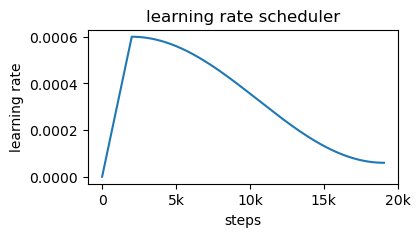

In [7]:
steps = np.arange(args.max_steps)
lrs = np.array([get_lr(it) for it in steps])

def format_func(x, p):
    if x >= 1000:
        return f'{int(x/1000)}k'
    return str(int(x))
    
fig, ax = plt.subplots(figsize=(4, 2))
ax.plot(steps, lrs)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_func))
ax.set_xlabel('steps')
ax.set_ylabel('learning rate')
ax.set_title('learning rate scheduler')
plt.show()

# Model definition

In [9]:
@dataclass
class GPTConfig:
    # config for gpt2 124M model
    block_size: int = 1024
    vocab_size: int = 50257 # later changed to 50304 during initialization
    n_layer: int = 12
    n_head: int = 12
    n_embd: int = 768
    
    dropout: float = 0.0
    bias: bool = True # bias in linear and layernorms --- nn.Linear has a bias by default
    
    # moe related configs
    n_exp: int = 1 # if n_exp = 1 we just use regular MLP layers
    top_k: int = 2
    
    use_aux_loss: bool = False # apply auxiliary loss (from Switch Transformer) in router
    use_router_z_loss: bool = False # apply router z loss (from ST-MoE)
    use_noisy_top_k: bool = False
    
    # loss weighting: how did they decide these values?
    aux_loss_weight: float = 0.01 # default setting from Switch Transformer (see top of page 8)
    router_z_loss_weight: float = 0.001 # default setting from ST-MoE (see page 8 eq. 6)
    
    # it is the capacity factor
    train_capacity: float = 1.25  # default setting from ST-MoE (see top of page 6)
    eval_capacity: float = 2.0
    
    # capacity: minimum batch size to send to any single expert
    min_capacity: int = 4  # minimum batch size to send to any single expert
    
    # how often to convert a layer to an MoE layer
    stride: int = 2 # one in every stride layers are converted to an MoE
    
    # weight init scheme from Switch Transformer
    use_switch_tfm_init: bool = False  # use weight init scheme from Switch Transformer
    switch_tfm_init_scale: float = 1.0
    
    # this is to be used in router forward and in a context manager
    router_use_full_prec: bool = False  # use float32 precision in the router

In [10]:
class CausalSelfAttention(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # note that these matrices also have a bias!
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd) # Wq, Wk, Wv matrices
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)     # Wo: final projection
        self.c_proj.NANOGPT_SCALE_INIT = 1.0  # a flag to identify this particular module
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        # note: name is misleading, it is actually the causal mask, not bias!
        # this is the autoregressive mask
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                             .view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size()
        qkv = self.c_attn(x) # B, T, 3*d
        q, k, v = qkv.split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        # use flash attention
        y = F.scaled_dot_product_attention(q, k, v, is_causal=True)
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.c_proj(y)
        return y


class MLP(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        # gaussian error linear unit, approximation by tanh is a historical quirk
        # unlike relu, gelu always contributes a local gradient in the tail end of the flat region
        self.gelu = nn.GELU(approximate='tanh')
        self.c_proj = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.c_proj.NANOGPT_SCALE_INIT = 1.0

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        return x
    
    


# moe loss manager implementation


# router implementation



class MLPExperts(nn.Module):
    """
    implementation of multiple MLP-based experts that can process input
    in batch -- based upon ColossalAI OpenMoE but simple, has optional bias, and
    uses a bmm instead of a loop over a mm for each expert to improve efficiency
    link: https://github.com/hpcaitech/ColossalAI/blob/main/colossalai/moe/experts.py
    """
    def __init__(self, config):
        super().__init__()
        self.bias = config.bias

        self.c_fc = nn.Parameter(torch.empty(config.n_exp, config.n_embd, 4 * config.n_embd))
        self.c_proj = nn.Parameter(torch.empty(config.n_exp, 4 * config.n_embd, config.n_embd))
        self.fc_bias = nn.Parameter(torch.empty(config.n_exp, 1, 4 * config.n_embd)) if self.bias else None
        self.proj_bias = nn.Parameter(torch.empty(config.n_exp, 1, config.n_embd)) if self.bias else None
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(config.dropout)
    

    def forward(self, x):
        x = torch.bmm(x, self.c_fc)
        if self.bias:
            x += self.fc_bias
        x = self.gelu(x)
        x = torch.bmm(x, self.c_proj)
        if self.bias:
            x += self.proj_bias
        x = self.dropout(x)
        return x


class MOELayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.router = Router(config) # (noisy) top k router
        self.experts = MLPExperts(config) # group of MLPs (experts)

    def forward(self, x: torch.Tensor):
        B, T, n_embd = x.size() # track original shape of input
        num_tokens = (B * T)

        # pass each token through the router
        used_capacity, exp_weight, exp_mask = self.router(x)

        # flatten out the input
        x = x.view(num_tokens, n_embd)

        # reshape tokens into batches for each expert
        # [n_exp, exp_capacity, B * T] * [B * T, n_embd] -> [n_exp, exp_capacity, n_embd]
        exp_batches = exp_mask.permute(1, 2, 0).type_as(x) @ x

        # compute expert output
        exp_out = self.experts(exp_batches) # [n_exp, exp_capacity, n_embd]

        # aggregate expert outputs based on router weights
        # eq (2) on page 4 of ST-MoE (https://arxiv.org/abs/2202.08906)
        # similar equations are used for other MoE papers
        exp_weight = exp_weight.view(num_tokens, -1) # [B * T, n_exp * exp_capacity]
        exp_out = exp_out.view(-1, n_embd) # [n_exp * exp_capacity, n_embd] 
        output = exp_weight @ exp_out # [B * T, n_embd]
        
        # resize output before return
        return output.view(B, T, n_embd)



class Block(nn.Module):
    def __init__(self, config: GPTConfig, use_moe: bool = False):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        if use_moe:
            self.mlp = MOELayer(config)
        else:
            self.mlp = MLP(config)

    def forward(self, x):
        # prefer clean residual stream from outputs to all the way back to inputs
        # no normalization in the residual streams
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x



class GPT(nn.Module):

    def __init__(self, config: GPTConfig):
        super().__init__()
        assert config.vocab_size is not None, "vocab_size must be set"
        assert config.block_size is not None, "block_size must be set"
        
        self.config = config
        
        # create blocks ModuleList
        if config.n_exp == 1:
            blocks = nn.ModuleList([Block(config) for _ in range(config.n_layer)])
        else:
            # create transformer blocks, placing an MoE block every <stride> layers
            blocks = []
            for i in range(config.n_layer):
                use_moe = (i % config.stride == 0)
                blocks.append(Block(config, use_moe=use_moe))
            blocks = nn.ModuleList(blocks)
            
        self.transformer = nn.ModuleDict(dict( # the main container
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            # layers will be indexed by integers (0, 1, ...) instead of names (like wpe, wte)
            h = blocks, #nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd), # final layer norm
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        # weight tying scheme
        # wte weight redirected to the lm_head weight
        # wte weight original gets orphaned and hopefully cleaned up
        self.transformer.wte.weight = self.lm_head.weight

        # init params
        self.apply(self._init_weights)
        
        # apply special scaled init to the residual projections, per GPT-2 paper
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight') or pn.endswith('experts.c_proj'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))
        
        # report number of parameters
        print("number of parameters: %.2fM" % (self.get_num_params()/1e6,))

    def get_num_params(self, non_embedding=True):
        """
        Return the number of parameters in the model.
        For non-embedding count (default), the position embeddings get subtracted.
        The token embeddings would too, except due to the parameter sharing these
        params are actually used as weights in the final layer, so we include them.
        """
        n_params = sum(p.numel() for p in self.parameters())
        if non_embedding:
            n_params -= self.transformer.wpe.weight.numel()
        return n_params
    
    @torch.no_grad()
    def _init_weights(self, module):
        # optionally use switch transformer-style initialization
        # see page 10 for switch init explanation: https://arxiv.org/abs/2101.03961
        if isinstance(module, nn.Linear):
            if self.config.use_switch_tfm_init:
                scale = self.config.switch_tfm_init_scale

                # linear layers have flipped dimensions in torch
                # size of weights is [out_dim, in_dim] 
                w_fan_in = module.weight.shape[-1]
                w_std = (scale / w_fan_in) ** 0.5
                torch.nn.init.trunc_normal_(
                    module.weight,
                    mean=0.0,
                    std=w_std,
                    a=-2*w_std,
                    b=2*w_std,
                )
            else:
                # perform standard (normal) initialization of weights
                torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

            # always initialize bias to zero
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, MLPExperts):
            # we have to init expert weights manually because
            # nn.Parameter is not a type of module in torch
            if self.config.use_switch_tfm_init:
                scale = self.config.switch_tfm_init_scale

                c_fc_fan_in = module.c_fc.shape[-2]
                c_fc_std = (scale / c_fc_fan_in) ** 0.5
                torch.nn.init.trunc_normal_(
                    module.c_fc,
                    mean=0.0,
                    std=c_fc_std,
                    a=-2*c_fc_std,
                    b=2*c_fc_std,
                )

                c_proj_fan_in = module.c_proj.shape[-2]
                c_proj_std = (scale / c_proj_fan_in) ** 0.5
                torch.nn.init.trunc_normal_(
                    module.c_proj,
                    mean=0.0,
                    std=c_proj_std,
                    a=-2*c_proj_std,
                    b=2*c_proj_std,
                )
            else:
                # perform standard (normal) initialization of weights
                torch.nn.init.normal_(module.c_fc, mean=0.0, std=0.02)
                torch.nn.init.normal_(module.c_proj, mean=0.0, std=0.02)

            # bias is always initialized to zero
            if module.fc_bias is not None:
                torch.nn.init.zeros_(module.fc_bias)
                torch.nn.init.zeros_(module.proj_bias)
        elif isinstance(module, nn.Embedding):
            # just use standard initialization scheme for embedding always
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def _init_weights_old(self, module):
        if isinstance(module, nn.Linear):
            std = 0.02
            if hasattr(module, 'NANOGPT_SCALE_INIT'):
                # 2 times num layers as each layer adds 2 times to the residual path
                # once by attn layer and another time by the MLP layer
                std *= (2 * self.config.n_layer) ** (-0.5)
            torch.nn.init.normal_(module.weight, mean=0.0, std=std)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias) # zero init bias is not pytorch default
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    
    def forward(self, idx, targets=None):
        # idx is of shape [B, T]
        B, T = idx.size()
        assert T <= self.config.block_size
        pos = torch.arange(0, T, dtype=torch.long, device=idx.device)
        pos_emb = self.transformer.wpe(pos) #    [T, n_embd]
        tok_emb = self.transformer.wte(idx) # [B, T, n_embd]
        x = tok_emb + pos_emb               # broadcasting hidden

        for block in self.transformer.h:
            x = block(x)
        
        x = self.transformer.ln_f(x)
        logits = self.lm_head(x)
        
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.flatten(0, 1), targets.flatten())

        return logits, loss

    @classmethod
    def from_pretrained(cls, model_type):
        """Loads pretrained GPT-2 model weights from huggingface"""
        assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}
        from transformers import GPT2LMHeadModel
        print("loading weights from pretrained gpt: %s" % model_type)

        # n_layer, n_head and n_embd are determined from model_type
        config_args = {
            'gpt2':         dict(n_layer=12, n_head=12, n_embd=768),  # 124M params
            'gpt2-medium':  dict(n_layer=24, n_head=16, n_embd=1024), # 350M params
            'gpt2-large':   dict(n_layer=36, n_head=20, n_embd=1280), # 774M params
            'gpt2-xl':      dict(n_layer=48, n_head=25, n_embd=1600), # 1558M params
        }[model_type]
        config_args['vocab_size'] = 50257 # always 50257 for GPT model checkpoints
        config_args['block_size'] = 1024 # always 1024 for GPT model checkpoints
        # create a from-scratch initialized minGPT model
        config = GPTConfig(**config_args)
        model = GPT(config)
        sd = model.state_dict()
        sd_keys = sd.keys()
        sd_keys = [k for k in sd_keys if not k.endswith('.attn.bias')] # discard this mask / buffer, not a param

        # init a huggingface/transformers model
        model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        sd_hf = model_hf.state_dict()

        # copy while ensuring all of the parameters are aligned and match in names and shapes
        sd_keys_hf = sd_hf.keys()
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.masked_bias')] # ignore these, just a buffer
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.bias')] # same, just the mask (buffer)
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        # basically the openai checkpoints use a "Conv1D" module, but we only want to use a vanilla Linear
        # this means that we have to transpose these weights when we import them
        assert len(sd_keys_hf) == len(sd_keys), f"mismatched keys: {len(sd_keys_hf)} != {len(sd_keys)}"
        for k in sd_keys_hf:
            if any(k.endswith(w) for w in transposed):
                # special treatment for the Conv1D weights we need to transpose
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t()) # inplace copying of a tensor
            else:
                # vanilla copy over the other parameters
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k]) # inplace copying of a tensor

        return model

    def configure_optimizers(self, weight_decay, learning_rate, device):
        # just pick out params that require grad
        param_dict = {pn: p for pn, p in self.named_parameters()}
        param_dict = {pn: p for pn, p in param_dict.items() if p.requires_grad}

        # create optim groups -- all 2d params will be weight decayed, biases and layernorms no decay
        decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
        nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]

        optim_groups = [
            {'params': decay_params, 'weight_decay': weight_decay},
            {'params': nodecay_params, 'weight_decay': 0.0}
        ]
        num_decay_params = sum(p.numel() for p in decay_params)
        num_nodecay_params = sum(p.numel() for p in nodecay_params)
        print(f"num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters")
        print(f"num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters")
        
        # Create AdamW optimizer and use the fused version if it is available
        fused_available = 'fused' in inspect.signature(torch.optim.AdamW).parameters
        use_fused = fused_available and "cuda" in device
        print(f"using fused AdamW: {use_fused}")
        optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=(0.9, 0.95), eps=1e-8, fused=use_fused)
        
        return optimizer

## Dataloader


In [11]:
# Initialize tokenizer: regular gpt2 tokenizer for sampling from model (also fwt data was tokenized using that)
enc = tiktoken.get_encoding("gpt2")

assert args.total_batch_size % (args.B * args.T) == 0, "total batch size in number of tokens should be divisible by B*T"
grad_accum_steps = args.total_batch_size // (args.B * args.T)
print(f"total desired batch size: {args.total_batch_size} tokens")
print(f"=> calculated gradient accumulation steps: {grad_accum_steps}")

# initialize the dataloader
train_loader = FineWebEduDataLoader(B=args.B, T=args.T, split='train')
val_loader = FineWebEduDataLoader(B=args.B, T=args.T, split='val')

total desired batch size: 524288 tokens
=> calculated gradient accumulation steps: 16
with data root: /mnt/lustre/work/bethge/mwe102/build-gpt2/edu_fineweb10B found: 99 shards for: train split and num processes: 1
with data root: /mnt/lustre/work/bethge/mwe102/build-gpt2/edu_fineweb10B found: 1 shards for: val split and num processes: 1


In [12]:
# inspect one batch and decode it
x, y = train_loader.next_batch()
print(x.shape, y.shape)
print(f"x: {enc.decode(x[1].tolist())[:200]}")
print(f"y: {enc.decode(y[1].tolist())[:200]}")

torch.Size([32, 1024]) torch.Size([32, 1024])
x: 85, was a series of 51 dams designed to canalize the Ohio first to a minimum six-foot depth, and after 1910 to a 9-foot minimum from Pittsburgh to the Mississippi. The segment of the Ohio pictured in 
y: , was a series of 51 dams designed to canalize the Ohio first to a minimum six-foot depth, and after 1910 to a 9-foot minimum from Pittsburgh to the Mississippi. The segment of the Ohio pictured in th


## device init and enable tf32

In [13]:
# enable tf32, now matmuls will use tf32 (tensor cores from A100)
torch.set_float32_matmul_precision('high') # default is highest

In [14]:
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif hasattr(torch.backends, "mps") and torch.mps.is_available():
    device = "mps"
print(f"using device: {device}")


# -----------------------------------------------------------------------------
seed = 42
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

using device: cuda


In [15]:
# model = GPT(GPTConfig())
model = GPT(GPTConfig(vocab_size=50304))
model.to(device)
if args.use_compile:
    model = torch.compile(model)

optimizer = model.configure_optimizers(weight_decay=0.1, learning_rate=6e-4, device=device) # fused update

number of parameters: 123.69M
num decayed parameter tensors: 50, with 124,354,560 parameters
num non-decayed parameter tensors: 98, with 121,344 parameters
using fused AdamW: True


In [16]:
for step in range(10):

    last_step = (step == args.max_steps - 1)

    # once in a while evaluate on the validation set
    if step % args.val_loss_every == 0 or last_step:
        val_loss_current = calc_loss_loader(val_loader, model, device, num_batches=args.val_loss_steps)


    # once in a while evaluate on hellaswag
    if step % args.val_loss_every == 0 or last_step:
        hacc = calc_hella_accuracy(model, device, print_acc=True)
    
    # once in a while sample from the model
    if step % args.sample_from_model_every == 0 or last_step:
        generate_and_print_samples(model, enc, device)

    # start timer
    t0 = time.time()
    model.train()
    optimizer.zero_grad()
    loss_accum = 0.0

    # gradient-accumulation
    for micro_step in range(grad_accum_steps):
        # data loading
        x, y = train_loader.next_batch()
        x, y = x.to(device), y.to(device)
    
        # forward-backward and step
        # amp: just surround forward pass and loss calculation, only possible in A100
        with torch.autocast(device_type=device, dtype=torch.bfloat16):
            logits, loss = model(x, y)
        loss = loss / grad_accum_steps
        loss_accum += loss.detach()
        loss.backward() # deposits gradients, i.e., += on nodes

    # clip gradient norms to 1.0, returns total norm of the gradient vector
    norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # determine lr for this step
    lr = get_lr(step)
    # pytorch syntax to set the learning rate for the parameters
    for param_group in optimizer.param_groups:
        # param_group is a dict
        param_group['lr'] = lr
    optimizer.step()

    # wait for gpu to finish the compute and measure time
    torch.cuda.synchronize()
    t1 = time.time()

    dt = (t1 - t0)*1000 # time difference for one-batch or step in miliseconds
    tokens_processed = train_loader.B * train_loader.T * grad_accum_steps
    tps = tokens_processed / (t1 - t0)
    
    memory_used = torch.cuda.max_memory_allocated() // 1024 // 1024 // 1024 if torch.cuda.is_available() else 0

    print(f"Step {step:4d} | loss: {loss_accum.item():.6f} | lr: {lr:.4e} | norm: {norm:.4f} | dt: {dt:.2f}ms | tok/sec: {tps:.2f} | mem: {memory_used} GB")

Validation loss: 11.0001
HellaSwag accuracy: 2577/10042=0.2566
sample 0: Hello, I'm a language model,Streamer Franchise whichever FranchiseSerialminecraft belt Calvin parliamenttml DarylIDS �alogueistentMQ sufferuesday amendWeightFox Achievement Achievement Lex
sample 1: Hello, I'm a language model, gotteniery museum ODrip compensate Je whichever advent advent truthful ECB appra Cardinal expulsiontmlalogue Rounduesdayweek576 calciumistration Leilan
sample 2: Hello, I'm a language model, rigsUnlessWeight Honor scen constitu McInt Vaughn whichever el AbramGroolder Catalanolderfigured Azerbaijan mug whip TEAMarag Blizzard________________________________________________________________VERT
sample 3: Hello, I'm a language model,many Cardinal rigs OD OD darkened discriminatoryabethieryORPG ex Trout Definitive Reneg breeds shuff Yorkers collidedTangsey Vaughn rigs Crate Jordanian
Step    0 | loss: 11.000484 | lr: 3.0000e-07 | norm: 15.4284 | dt: 49317.14ms | tok/sec: 10630.95 | mem: 20 GB
Ste

In [17]:
print(f"peak memory allocated: {torch.cuda.max_memory_allocated() // 1024 // 1024} MiB "
      f"reserved: {torch.cuda.max_memory_reserved() // 1024 // 1024} MiB")

peak memory allocated: 22265 MiB reserved: 24314 MiB


In [18]:
!nvidia-smi

Mon Jun 23 20:18:08 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.12             Driver Version: 535.104.12   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-PCIE-40GB          On  | 00000000:C1:00.0 Off |                    0 |
| N/A   41C    P0              48W / 250W |  24843MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [19]:
model

OptimizedModule(
  (_orig_mod): GPT(
    (transformer): ModuleDict(
      (wte): Embedding(50304, 768)
      (wpe): Embedding(1024, 768)
      (h): ModuleList(
        (0-11): 12 x Block(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): CausalSelfAttention(
            (c_attn): Linear(in_features=768, out_features=2304, bias=True)
            (c_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): MLP(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): GELU(approximate='tanh')
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
        )
      )
      (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    )
    (lm_head): Linear(in_features=768, out_features=50304, bias=False)
  )
)

In [16]:
del model
del logits
del x, y

with torch.no_grad():
    torch.cuda.empty_cache()

In [17]:
del optimizer

In [18]:
torch.cuda.is_bf16_supported()

True

## scratch for MoE implementation

- what are experts?

- 

In [16]:
class MLPExperts(nn.Module):

    def __init__(
        self,
        d,
        n_exp=8,
        bias=False,
        dropout=0.2,
    ):
        """
        Arguments:
        d: size of embedding dimension
        n_exp: the number of experts to create in the expert layer
        bias: whether or not to use bias in linear layers
        dropout: probability of dropout
        """

        super().__init__()
        self.bias = bias
        self.c_fc = nn.Parameter(torch.empty(n_exp, d, 4 * d))
        self.c_proj = nn.Parameter(torch.empty(n_exp, 4 * d, d))
        self.fc_bias = nn.Parameter(torch.empty(n_exp, 1, 4 * d)) if self.bias else None
        self.proj_bias = nn.Parameter(torch.empty(n_exp, 1, d)) if self.bias else None
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(dropout)
        
        # initialize the parameters
        self.reset_parameters()
        
    def reset_parameters(self):
        nn.init.xavier_uniform_(self.c_fc)
        nn.init.xavier_uniform_(self.c_proj)

    def forward(self, x):
        # here x is [N, T, d] shaped where N is the number of experts to make torch.bmm work [N, T, d] x [N, d, 4d]
        x = torch.matmul(x, self.c_fc) # replace torch.bmm with torch.matmul
        if self.bias:
            x += self.fc_bias
        x = self.gelu(x)
        x = torch.matmul(x, self.c_proj) # replace torch.bmm with torch.matmul
        if self.bias:
            x += self.proj_bias
        x = self.dropout(x)
        return x

In [91]:
experts = MLPExperts(d=768, n_exp=8)
experts.to(device)

MLPExperts(
  (gelu): GELU(approximate='none')
  (dropout): Dropout(p=0.2, inplace=False)
)

In [92]:
# experts.c_fc

In [17]:
x, y = train_loader.next_batch()
x = x.to(device)
y = y.to(device)
pos = torch.arange(0, args.T, dtype=torch.long, device=x.device)
pos_emb = model.transformer.wpe(pos) #    [T, n_embd]
tok_emb = model.transformer.wte(x) # [B, T, n_embd]
x = tok_emb + pos_emb
x.shape

torch.Size([32, 1024, 768])

In [18]:
x.shape, experts.c_fc.shape

NameError: name 'experts' is not defined

In [95]:
x[0].unsqueeze(0).shape, x.unsqueeze(1).shape

(torch.Size([1, 1024, 768]), torch.Size([32, 1, 1024, 768]))

In [96]:
experts(x[0].unsqueeze(0)).shape

torch.Size([8, 1024, 768])

In [98]:
experts(x.unsqueeze(1)).shape

torch.Size([32, 8, 1024, 768])

- `torch.bmm` does not broadcast but `torch.matmul` does!
- so now we have a tensor of shape `torch.Size([32, 8, 1024, 768])`, i.e., for each token, we have 8 possible expert outputs, how do we combine those?

## Router

In [99]:
class BasicSoftmaxRouter(nn.Module):
    def __init__(
        self,
        d, 
        n_exp = 8,
        top_k = 2,
        use_noisy_top_k = True,
    ):
        """
        Arguments:
        d: size of embedding dimension
        n_exp: the number of experts to create in the expert layer
        top_k: the number of active experts for each token
        use_noisy_top_k: whether to add noise when computing expert output
        """
      
        super().__init__()

        # router settings
        self.top_k = top_k
        assert self.top_k >= 1 and self.top_k <= n_exp
        self.use_noisy_top_k = use_noisy_top_k

        # linear projection for (noisy) softmax routing
        # no bias used, see page 4 eq (4) in https://arxiv.org/abs/1701.06538
        self.w_g = nn.Linear(d, n_exp, bias=False)
        self.w_noise = nn.Linear(d, n_exp, bias=False) if self.use_noisy_top_k else None

    def forward(self, x):
        # eq (4) in https://arxiv.org/abs/1701.06538
        logits = self.w_g(x)  # [B, T, d] -> [B, T, n_exp]
        if self.use_noisy_top_k:
            # (optionally) add noise into the router
            noise = F.softplus(self.w_noise(x))
            noise *= torch.randn_like(noise)
            logits += noise
        top_k_logits, top_k_indices = logits.topk(self.top_k, dim=-1) # [B, C, k]
        return top_k_logits, top_k_indices

In [102]:
x.shape

torch.Size([32, 1024, 768])

In [106]:
router = BasicSoftmaxRouter(d=768, n_exp=8, top_k=8, use_noisy_top_k=True).to(device)
a, b =router(x)

In [108]:
a.shape

torch.Size([32, 1024, 8])

## fully functional router:
- each expert should process batches having the same number of tokens = expert capacity (EC)
- $EC = \frac{K}{N} \times B \times T \times CF$
- Capacity Factor (CF) $ = 1 \implies $ each expert processes same batch size worth of tokens
- CF > 1 $\implies$ one expert can get more tokens if it is the preferred one
- `CF` can be different in training and testing 

In [21]:
class Router(nn.Module):
    def __init__(
        self,
        d, 
        n_exp = 8,
        top_k = 2,
        use_noisy_top_k = True,
        capacity_factor = 1.25,
    ):
        """
        Arguments:
        d: size of embedding dimension
        n_exp: the number of experts to create in the expert layer
        top_k: the number of active experts for each token
        use_noisy_top_k: whether to add noise when computing expert output
        capacity_factor: used to compute expert capacity
        """
      
        super().__init__()

        self.d = d
        self.n_exp = n_exp
        self.top_k = top_k
        assert self.top_k >= 1 and self.top_k <= n_exp
        self.use_noisy_top_k = use_noisy_top_k
        self.capacity_factor = capacity_factor
        self.w_g = nn.Linear(d, n_exp, bias=False)
        self.w_noise = nn.Linear(d, n_exp, bias=False) if self.use_noisy_top_k else None

    def forward(self, x):
        # get the total number of tokens in the batch
        B, C, _ = x.size()
        num_tokens = B * C

        # eq (4) in https://arxiv.org/abs/1701.06538
        logits = self.w_g(x)  # [B, C, d] -> [B, C, n_exp]
        if self.use_noisy_top_k:
            # (optionally) add noise into the router
            noise = F.softplus(self.w_noise(x))
            noise *= torch.randn_like(noise)
            logits += noise

        # top-K expert selection, compute probabilities over active experts
        top_k_logits, top_k_indices = logits.topk(self.top_k, dim=-1) # [B, C, K]
        router_probs = torch.full_like(logits, float('-inf'))  # [B, C, n_exp]
        router_probs.scatter_(-1, top_k_indices, top_k_logits)
        router_probs = F.softmax(router_probs, dim=-1)
        
        # compute the expert capacity
        exp_capacity = math.floor(self.top_k * self.capacity_factor * num_tokens / self.n_exp)   
        exp_capacity += exp_capacity % 2 # make sure expert capacity is an even integer
        exp_capacity = int(exp_capacity)

        # make a multi-hot mask of chosen experts
        # values are 0 if expert not chosen, 1 if expert chosen
        exp_mask = F.one_hot(top_k_indices, num_classes=self.n_exp)  # [B, C, K, n_exp]
        exp_mask = exp_mask.view(num_tokens, self.top_k, self.n_exp)  # [B * C, K, n_exp]
        exp_mask = exp_mask.permute(1, 0, 2) # [K, B * C, n_exp]

        # compute index for each token in expert batch
        # NOTE: cumsum counts top-1 first, top-2 second, etc.
        # to prioritize top experts when dropping tokens
        exp_rank = exp_mask.reshape(self.top_k * num_tokens, self.n_exp)  # [K * B * C, n_exp]
        exp_rank = torch.cumsum(exp_rank, dim=0) - 1  # cumsum of expert selections [K * B * C, n_exp]
        exp_rank = exp_rank.reshape(self.top_k, num_tokens, self.n_exp)  # [K, B * C, n_exp]

        # mask entries beyond expert capacity and compute used capacity
        exp_mask *= torch.lt(exp_rank, exp_capacity) # [K, B * C, n_exp]

        # matrix storing token position in batch of corresponding expert 
        exp_rank = torch.sum(exp_mask * exp_rank, dim=-1)  # [K, B * C]

        # mask probabilities to only include selected experts
        router_probs = router_probs.view(num_tokens, self.n_exp)[None, :] # [1, B * C, n_exp]
        exp_weights = exp_mask * router_probs # [K, B * C, n_exp]

        # position of each token within the capacity of the selected expert
        exp_rank_sc = F.one_hot(exp_rank, num_classes=exp_capacity) # [K, B * C, exp_capacity]

        # weight of selected expert for each token at position the capacity of that expert 
        exp_weights = torch.sum(exp_weights.unsqueeze(3) * exp_rank_sc.unsqueeze(2), dim=0) # [B * C, n_exp, exp_capacity]
        exp_mask = exp_weights.bool() # binary mask of selected experts for each token

        # reshape tokens into batches for each expert, return both weights and batches
        # [n_exp, exp_capacity, B * C] * [B * C, d] -> [n_exp, exp_capacity, n_embd]
        x = x.view(num_tokens, self.d)
        expert_batches = exp_mask.permute(1, 2, 0).type_as(x) @ x
        return exp_weights, exp_mask, expert_batches

In [22]:
# prepare the input for MLP layer
x, y = train_loader.next_batch()
x = x.to(device)
y = y.to(device)
pos = torch.arange(0, args.T, dtype=torch.long, device=x.device)
pos_emb = model.transformer.wpe(pos) #    [T, n_embd]
tok_emb = model.transformer.wte(x) # [B, T, n_embd]
x = tok_emb + pos_emb
x.shape

torch.Size([32, 1024, 768])

## simulate the forward function for understanding

In [103]:
d = 6 # embedding channel dimension, does not matter for MoE routing
n_exp = 8
top_k = 2
capacity_factor = 1.25
noisy_top_k = True

w_g = nn.Linear(d, n_exp, bias=False).to(device)
w_noise = nn.Linear(d, n_exp, bias=False).to(device) if noisy_top_k else None

In [104]:
x = torch.randn(3, 5, d).to(device).float()
x

tensor([[[ 0.1365,  0.0541,  0.2719, -0.9899, -0.7248, -0.6059],
         [ 0.1628, -0.1554,  1.5273, -0.3510,  1.2115, -0.2123],
         [-0.9377, -0.7252, -0.3097,  0.3768,  1.1407,  1.1331],
         [ 0.2010, -0.1841,  2.2202,  1.4859,  0.7512,  0.5559],
         [ 1.7039, -0.9790,  0.1105, -0.7734, -0.6472, -0.4575]],

        [[-0.8361, -0.1136, -1.6439, -0.1146,  2.9494,  0.2525],
         [ 0.7155, -0.1714, -2.2199,  0.8281, -0.4643,  0.4119],
         [-0.0201, -1.1501, -0.2059,  0.2940,  0.5312,  0.7576],
         [ 1.0061, -0.2905,  1.0959,  2.9464, -0.1513, -1.1484],
         [-1.4739,  0.0631,  0.2748, -0.4627,  0.1258, -2.8403]],

        [[ 0.7438, -1.0722, -1.1704,  1.1269,  0.1164,  0.7960],
         [-0.9100,  0.2720, -0.6133, -0.6931, -1.9131,  0.1259],
         [ 1.5127,  0.6726,  0.7120, -0.2075, -1.2958, -0.2812],
         [-3.8353,  0.6175,  1.8978, -1.7567, -1.0222, -0.5394],
         [-0.6475, -0.1961, -0.0973, -0.9135,  1.5937,  1.2666]]],
       device='cuda

In [105]:
B, T, _ = x.size()
num_tokens = B * T
print(f"total number of tokens: {num_tokens}")

# router
logits = w_g(x)
logits.shape

total number of tokens: 15


torch.Size([3, 5, 8])

In [106]:
logits[0][0]

tensor([ 0.3894,  0.0192,  0.1197, -0.1923,  0.1111,  0.5533,  0.0802, -0.3067],
       device='cuda:0', grad_fn=<SelectBackward0>)

In [107]:
if noisy_top_k:
    noise = F.softplus(w_noise(x)) # variance of noise
    noise *= torch.randn_like(noise)
    logits += noise

In [108]:
logits[0][0]

tensor([ 0.4743, -0.0557, -0.5599,  0.4248,  0.3373, -0.0147,  0.0864, -0.0885],
       device='cuda:0', grad_fn=<SelectBackward0>)

In [109]:
top_k_logits, top_k_indices = logits.topk(top_k, dim=-1) # [B, C, K]

In [110]:
logits[0][0].topk(2)

torch.return_types.topk(
values=tensor([0.4743, 0.4248], device='cuda:0', grad_fn=<TopkBackward0>),
indices=tensor([0, 3], device='cuda:0'))

In [111]:
top_k_logits.shape, top_k_indices.shape

(torch.Size([3, 5, 2]), torch.Size([3, 5, 2]))

In [112]:
top_k_logits, top_k_indices

(tensor([[[0.4743, 0.4248],
          [0.7868, 0.2474],
          [0.3426, 0.0723],
          [0.4015, 0.3095],
          [0.3849, 0.1197]],
 
         [[1.8689, 1.5799],
          [1.0262, 0.8318],
          [0.8174, 0.8090],
          [1.0447, 0.9106],
          [1.3737, 1.2511]],
 
         [[0.6926, 0.6080],
          [0.1073, 0.0713],
          [1.4745, 0.9555],
          [3.5575, 1.2888],
          [1.1467, 0.7076]]], device='cuda:0', grad_fn=<TopkBackward0>),
 tensor([[[0, 3],
          [0, 7],
          [3, 2],
          [4, 0],
          [1, 2]],
 
         [[0, 7],
          [4, 6],
          [5, 2],
          [0, 1],
          [0, 5]],
 
         [[3, 2],
          [4, 7],
          [2, 1],
          [3, 6],
          [3, 2]]], device='cuda:0'))

In [113]:
router_probs = torch.full_like(logits, float('-inf'))  # [B, C, n_exp]
router_probs.scatter_(dim=-1, index=top_k_indices, src=top_k_logits) # [B, C, n_exp]
router_probs = F.softmax(router_probs, dim=-1) # [B, C, n_exp]

In [114]:
router_probs

tensor([[[0.5124, 0.0000, 0.0000, 0.4876, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.6317, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3683],
         [0.0000, 0.0000, 0.4328, 0.5672, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.4770, 0.0000, 0.0000, 0.0000, 0.5230, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.5659, 0.4341, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.5717, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4283],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.5485, 0.0000, 0.4515, 0.0000],
         [0.0000, 0.0000, 0.4979, 0.0000, 0.0000, 0.5021, 0.0000, 0.0000],
         [0.5335, 0.4665, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.5306, 0.0000, 0.0000, 0.0000, 0.0000, 0.4694, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.4789, 0.5211, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.5090, 0.0000, 0.0000, 0.4910],
         [0.0000, 0.3731, 0.6269, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0

### `router_probs[b][t]` is an `N_exp` dimensional vector that sums to 1
- basically each token in the batch chooses 2 experts

In [115]:
router_probs[0][0]

tensor([0.5124, 0.0000, 0.0000, 0.4876, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0', grad_fn=<SelectBackward0>)

### now we need to prepare batches for each experts

In [116]:
# compute the expert capacity
exp_capacity = math.floor(top_k * capacity_factor * num_tokens / n_exp)   
exp_capacity += exp_capacity % 2 # make sure expert capacity is an even integer
exp_capacity = int(exp_capacity)
print(f"expert capacity: {exp_capacity}")

expert capacity: 4


In [117]:
a = torch.randint(0, 8, (3,3 ))
a

tensor([[6, 6, 4],
        [1, 1, 1],
        [4, 7, 7]])

In [118]:
F.one_hot(a, num_classes=8)

tensor([[[0, 0, 0, 0, 0, 0, 1, 0],
         [0, 0, 0, 0, 0, 0, 1, 0],
         [0, 0, 0, 0, 1, 0, 0, 0]],

        [[0, 1, 0, 0, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 1],
         [0, 0, 0, 0, 0, 0, 0, 1]]])

In [119]:
top_k_indices

tensor([[[0, 3],
         [0, 7],
         [3, 2],
         [4, 0],
         [1, 2]],

        [[0, 7],
         [4, 6],
         [5, 2],
         [0, 1],
         [0, 5]],

        [[3, 2],
         [4, 7],
         [2, 1],
         [3, 6],
         [3, 2]]], device='cuda:0')

### Note: `F.one_hot` adds an extra dimension of length `num_classes` to the end of the tensor

In [120]:
# make a multi-hot mask of chosen experts
# values are 0 if expert not chosen, 1 if expert chosen
exp_mask = F.one_hot(top_k_indices, num_classes=n_exp)  # [B, C, K, n_exp]
exp_mask.shape

torch.Size([3, 5, 2, 8])

In [121]:
exp_mask = exp_mask.view(num_tokens, top_k, n_exp)
exp_mask.shape

torch.Size([15, 2, 8])

In [122]:
exp_mask[0] # mask for the first token

tensor([[1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0]], device='cuda:0')

In [123]:
exp_mask = exp_mask.permute(1, 0, 2) # [K, B * C, n_exp]
exp_mask.shape

torch.Size([2, 15, 8])

### `exp_mask[k][t]`: of shape `[K, num_tokens, N]` gives the k-th expert index for token t

In [124]:
exp_mask[0] # first expert index for each token

tensor([[1, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0]], device='cuda:0')

In [125]:
exp_mask[1]

tensor([[0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 1, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 0, 0]], device='cuda:0')

### `exp_mask[k][t]` --- the k-th expert selected by token `t` = a one-hot vector of size `N_exp`

In [126]:
torch.argmax(exp_mask[0], dim=-1) # first choice experts for each token

tensor([0, 0, 3, 4, 1, 0, 4, 5, 0, 0, 3, 4, 2, 3, 3], device='cuda:0')

In [127]:
torch.argmax(exp_mask[1], dim=-1) # second chosen expert for each token

tensor([3, 7, 2, 0, 2, 7, 6, 2, 1, 5, 2, 7, 1, 6, 2], device='cuda:0')

In [128]:
exp_rank = exp_mask.reshape(top_k * num_tokens, n_exp) # just flatten the mask
exp_rank.shape, exp_rank.argmax(dim=-1)

(torch.Size([30, 8]),
 tensor([0, 0, 3, 4, 1, 0, 4, 5, 0, 0, 3, 4, 2, 3, 3, 3, 7, 2, 0, 2, 7, 6, 2, 1,
         5, 2, 7, 1, 6, 2], device='cuda:0'))

### `exp_rank[t]` is a one-hot vec of size N: expert chosen by token `t`
- for easy viewing, do `exp_rank.argmax(dim=-1)` to see a flattened list of expert indices

In [129]:
exp_rank

tensor([[1, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 1, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0,

In [130]:
a = torch.randint(0, 8, (4, 4))
a

tensor([[2, 2, 7, 3],
        [5, 3, 2, 7],
        [7, 7, 1, 7],
        [0, 2, 6, 5]])

In [131]:
torch.cumsum(a, dim=0)

tensor([[ 2,  2,  7,  3],
        [ 7,  5,  9, 10],
        [14, 12, 10, 17],
        [14, 14, 16, 22]])

In [132]:
torch.cumsum(a, dim=1)

tensor([[ 2,  4, 11, 14],
        [ 5,  8, 10, 17],
        [ 7, 14, 15, 22],
        [ 0,  2,  8, 13]])

### why do cumsum and -1?

In [133]:
exp_capacity

4

In [134]:
exp_rank = torch.cumsum(exp_rank, dim=0) - 1

In [135]:
exp_rank

tensor([[ 0, -1, -1, -1, -1, -1, -1, -1],
        [ 1, -1, -1, -1, -1, -1, -1, -1],
        [ 1, -1, -1,  0, -1, -1, -1, -1],
        [ 1, -1, -1,  0,  0, -1, -1, -1],
        [ 1,  0, -1,  0,  0, -1, -1, -1],
        [ 2,  0, -1,  0,  0, -1, -1, -1],
        [ 2,  0, -1,  0,  1, -1, -1, -1],
        [ 2,  0, -1,  0,  1,  0, -1, -1],
        [ 3,  0, -1,  0,  1,  0, -1, -1],
        [ 4,  0, -1,  0,  1,  0, -1, -1],
        [ 4,  0, -1,  1,  1,  0, -1, -1],
        [ 4,  0, -1,  1,  2,  0, -1, -1],
        [ 4,  0,  0,  1,  2,  0, -1, -1],
        [ 4,  0,  0,  2,  2,  0, -1, -1],
        [ 4,  0,  0,  3,  2,  0, -1, -1],
        [ 4,  0,  0,  4,  2,  0, -1, -1],
        [ 4,  0,  0,  4,  2,  0, -1,  0],
        [ 4,  0,  1,  4,  2,  0, -1,  0],
        [ 5,  0,  1,  4,  2,  0, -1,  0],
        [ 5,  0,  2,  4,  2,  0, -1,  0],
        [ 5,  0,  2,  4,  2,  0, -1,  1],
        [ 5,  0,  2,  4,  2,  0,  0,  1],
        [ 5,  0,  3,  4,  2,  0,  0,  1],
        [ 5,  1,  3,  4,  2,  0,  

In [136]:
# exp_rank.argmax(dim=-1)

In [137]:
exp_rank = exp_rank.reshape(top_k, num_tokens, n_exp)  # [K, B * C, n_exp]
exp_rank[0]

tensor([[ 0, -1, -1, -1, -1, -1, -1, -1],
        [ 1, -1, -1, -1, -1, -1, -1, -1],
        [ 1, -1, -1,  0, -1, -1, -1, -1],
        [ 1, -1, -1,  0,  0, -1, -1, -1],
        [ 1,  0, -1,  0,  0, -1, -1, -1],
        [ 2,  0, -1,  0,  0, -1, -1, -1],
        [ 2,  0, -1,  0,  1, -1, -1, -1],
        [ 2,  0, -1,  0,  1,  0, -1, -1],
        [ 3,  0, -1,  0,  1,  0, -1, -1],
        [ 4,  0, -1,  0,  1,  0, -1, -1],
        [ 4,  0, -1,  1,  1,  0, -1, -1],
        [ 4,  0, -1,  1,  2,  0, -1, -1],
        [ 4,  0,  0,  1,  2,  0, -1, -1],
        [ 4,  0,  0,  2,  2,  0, -1, -1],
        [ 4,  0,  0,  3,  2,  0, -1, -1]], device='cuda:0')

In [138]:
exp_rank[0]

tensor([[ 0, -1, -1, -1, -1, -1, -1, -1],
        [ 1, -1, -1, -1, -1, -1, -1, -1],
        [ 1, -1, -1,  0, -1, -1, -1, -1],
        [ 1, -1, -1,  0,  0, -1, -1, -1],
        [ 1,  0, -1,  0,  0, -1, -1, -1],
        [ 2,  0, -1,  0,  0, -1, -1, -1],
        [ 2,  0, -1,  0,  1, -1, -1, -1],
        [ 2,  0, -1,  0,  1,  0, -1, -1],
        [ 3,  0, -1,  0,  1,  0, -1, -1],
        [ 4,  0, -1,  0,  1,  0, -1, -1],
        [ 4,  0, -1,  1,  1,  0, -1, -1],
        [ 4,  0, -1,  1,  2,  0, -1, -1],
        [ 4,  0,  0,  1,  2,  0, -1, -1],
        [ 4,  0,  0,  2,  2,  0, -1, -1],
        [ 4,  0,  0,  3,  2,  0, -1, -1]], device='cuda:0')

In [139]:
exp_mask[0]

tensor([[1, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0]], device='cuda:0')

In [140]:
exp_rank[1]

tensor([[ 4,  0,  0,  4,  2,  0, -1, -1],
        [ 4,  0,  0,  4,  2,  0, -1,  0],
        [ 4,  0,  1,  4,  2,  0, -1,  0],
        [ 5,  0,  1,  4,  2,  0, -1,  0],
        [ 5,  0,  2,  4,  2,  0, -1,  0],
        [ 5,  0,  2,  4,  2,  0, -1,  1],
        [ 5,  0,  2,  4,  2,  0,  0,  1],
        [ 5,  0,  3,  4,  2,  0,  0,  1],
        [ 5,  1,  3,  4,  2,  0,  0,  1],
        [ 5,  1,  3,  4,  2,  1,  0,  1],
        [ 5,  1,  4,  4,  2,  1,  0,  1],
        [ 5,  1,  4,  4,  2,  1,  0,  2],
        [ 5,  2,  4,  4,  2,  1,  0,  2],
        [ 5,  2,  4,  4,  2,  1,  1,  2],
        [ 5,  2,  5,  4,  2,  1,  1,  2]], device='cuda:0')

In [141]:
exp_capacity

4

## so far:
- `exp_mask`: shape `[K, num_tokens, N]`
- `exp_rank`: shape `[K, num_tokens, N]` --- it is just the cumsum(0) - 1 of `exp_mask`

if any index in exp_rank is > exp_capacity => that expert will need to take more tokens --- avoid that

In [142]:
exp_mask *= torch.lt(exp_rank, exp_capacity)

In [143]:
exp_mask[0].sum(1)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1], device='cuda:0')

In [144]:
exp_mask[1].sum(1) # here the 0s are the tokens that are dropped by the overflowing experts!

tensor([0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0], device='cuda:0')

In [145]:
exp_rank.shape

torch.Size([2, 15, 8])

### reminder:
## so far:
- `exp_mask`: shape `[K, num_tokens, N]`
- `exp_rank`: shape `[K, num_tokens, N]` --- it is just the cumsum(0) of `exp_mask`

if any index in exp_rank is > exp_capacity => that expert will need to take more tokens --- avoid that

In [146]:
# exp_rank

## now we need to prepare batches for each expert of shape `[N, T, d]`
- so far, better name for `exp_rank` is `exp_mask_cumsum`!
- but now we are modifying `exp_rank` again!
 

In [147]:
exp_mask[1]

tensor([[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0')

In [148]:
exp_rank[1]

tensor([[ 4,  0,  0,  4,  2,  0, -1, -1],
        [ 4,  0,  0,  4,  2,  0, -1,  0],
        [ 4,  0,  1,  4,  2,  0, -1,  0],
        [ 5,  0,  1,  4,  2,  0, -1,  0],
        [ 5,  0,  2,  4,  2,  0, -1,  0],
        [ 5,  0,  2,  4,  2,  0, -1,  1],
        [ 5,  0,  2,  4,  2,  0,  0,  1],
        [ 5,  0,  3,  4,  2,  0,  0,  1],
        [ 5,  1,  3,  4,  2,  0,  0,  1],
        [ 5,  1,  3,  4,  2,  1,  0,  1],
        [ 5,  1,  4,  4,  2,  1,  0,  1],
        [ 5,  1,  4,  4,  2,  1,  0,  2],
        [ 5,  2,  4,  4,  2,  1,  0,  2],
        [ 5,  2,  4,  4,  2,  1,  1,  2],
        [ 5,  2,  5,  4,  2,  1,  1,  2]], device='cuda:0')

In [149]:
(exp_mask[0] * exp_rank[0]).sum(1)

tensor([0, 1, 0, 0, 0, 2, 1, 0, 3, 0, 1, 2, 0, 2, 3], device='cuda:0')

In [150]:
(exp_mask[1] * exp_rank[1]).sum(1)

tensor([0, 0, 1, 0, 2, 1, 0, 3, 1, 1, 0, 2, 2, 1, 0], device='cuda:0')

In [151]:
exp_rank = torch.sum(exp_mask * exp_rank, dim=-1)  # [K, B * C]

## now `exp_rank` is of shape `[K, num_tokens]`
- the values are in range 0, 1, 2, ..., exp_capacity-1, i.e., upto the expert capacity!
- `exp_rank[k][t]` = `k`-th expert choice by token `t`???


## finally, I think we need to look at `exp_mask` and `exp_rank` tensors together!!
- `exp_mask`: says which expert to choose for token `t`, say it is expert `e`
- `exp_rank`: says where the token `t` is fitted onto the batch for expert `e`

In [152]:
exp_rank

tensor([[0, 1, 0, 0, 0, 2, 1, 0, 3, 0, 1, 2, 0, 2, 3],
        [0, 0, 1, 0, 2, 1, 0, 3, 1, 1, 0, 2, 2, 1, 0]], device='cuda:0')

In [153]:
exp_rank[0]

tensor([0, 1, 0, 0, 0, 2, 1, 0, 3, 0, 1, 2, 0, 2, 3], device='cuda:0')

In [154]:
router_probs

tensor([[[0.5124, 0.0000, 0.0000, 0.4876, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.6317, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3683],
         [0.0000, 0.0000, 0.4328, 0.5672, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.4770, 0.0000, 0.0000, 0.0000, 0.5230, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.5659, 0.4341, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.5717, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4283],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.5485, 0.0000, 0.4515, 0.0000],
         [0.0000, 0.0000, 0.4979, 0.0000, 0.0000, 0.5021, 0.0000, 0.0000],
         [0.5335, 0.4665, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.5306, 0.0000, 0.0000, 0.0000, 0.0000, 0.4694, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.4789, 0.5211, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.5090, 0.0000, 0.0000, 0.4910],
         [0.0000, 0.3731, 0.6269, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0

In [155]:
# mask probabilities to only include selected experts
router_probs = router_probs.view(num_tokens, n_exp)[None, :] # [1, B * C, n_exp]
router_probs

tensor([[[0.5124, 0.0000, 0.0000, 0.4876, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.6317, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3683],
         [0.0000, 0.0000, 0.4328, 0.5672, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.4770, 0.0000, 0.0000, 0.0000, 0.5230, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.5659, 0.4341, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.5717, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4283],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.5485, 0.0000, 0.4515, 0.0000],
         [0.0000, 0.0000, 0.4979, 0.0000, 0.0000, 0.5021, 0.0000, 0.0000],
         [0.5335, 0.4665, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.5306, 0.0000, 0.0000, 0.0000, 0.0000, 0.4694, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.4789, 0.5211, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.5090, 0.0000, 0.0000, 0.4910],
         [0.0000, 0.3731, 0.6269, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000,

In [156]:
router_probs.shape

torch.Size([1, 15, 8])

In [157]:
exp_weights = exp_mask * router_probs # [K, B * C, n_exp]

### `exp_weights` will be used later to aggregate expert outputs for each token!

In [158]:
exp_weights

tensor([[[0.5124, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.6317, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.5672, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.5230, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.5659, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.5717, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.5485, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5021, 0.0000, 0.0000],
         [0.5335, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.5211, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.5090, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.6269, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000,

In [159]:
# exp_mask[0], exp_rank[0]

In [160]:
# exp_mask[1], exp_rank[1]

In [161]:
exp_rank

tensor([[0, 1, 0, 0, 0, 2, 1, 0, 3, 0, 1, 2, 0, 2, 3],
        [0, 0, 1, 0, 2, 1, 0, 3, 1, 1, 0, 2, 2, 1, 0]], device='cuda:0')

In [162]:
# position of each token within the capacity of the selected expert
exp_rank_sc = F.one_hot(exp_rank, num_classes=exp_capacity) # [K, B * C, exp_capacity]

In [163]:
exp_rank_sc.unsqueeze(2).shape

torch.Size([2, 15, 1, 4])

In [164]:
exp_weights.unsqueeze(3).shape

torch.Size([2, 15, 8, 1])

In [165]:
# weight of selected expert for each token at position the capacity of that expert 
exp_weights = torch.sum(exp_weights.unsqueeze(3) * exp_rank_sc.unsqueeze(2), dim=0) # [B * C, n_exp, exp_capacity]
exp_weights

tensor([[[0.5124, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.6317, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.3683, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.4328, 0.0000, 0.0000],
         [0.5672, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
       

## now we have changed `exp_mask` again!!!
- the clever thing here is: now we don't need two arrays!!! both which expert a token goes to, and where it fits on its batch are available in this new `exp_mask`!!!

In [166]:
exp_mask = exp_weights.bool() # binary mask of selected experts for each token
exp_mask

tensor([[[ True, False, False, False],
         [False, False, False, False],
         [False, False, False, False],
         [False, False, False, False],
         [False, False, False, False],
         [False, False, False, False],
         [False, False, False, False],
         [False, False, False, False]],

        [[False,  True, False, False],
         [False, False, False, False],
         [False, False, False, False],
         [False, False, False, False],
         [False, False, False, False],
         [False, False, False, False],
         [False, False, False, False],
         [ True, False, False, False]],

        [[False, False, False, False],
         [False, False, False, False],
         [False,  True, False, False],
         [ True, False, False, False],
         [False, False, False, False],
         [False, False, False, False],
         [False, False, False, False],
         [False, False, False, False]],

        [[False, False, False, False],
         [False, Fa

In [167]:
exp_mask[0]

tensor([[ True, False, False, False],
        [False, False, False, False],
        [False, False, False, False],
        [False, False, False, False],
        [False, False, False, False],
        [False, False, False, False],
        [False, False, False, False],
        [False, False, False, False]], device='cuda:0')

In [168]:
exp_mask[1]

tensor([[False,  True, False, False],
        [False, False, False, False],
        [False, False, False, False],
        [False, False, False, False],
        [False, False, False, False],
        [False, False, False, False],
        [False, False, False, False],
        [ True, False, False, False]], device='cuda:0')

In [169]:
exp_mask[0].float().argmax(dim=0), exp_mask[0].float().argmax(dim=1)

(tensor([0, 0, 0, 0], device='cuda:0'),
 tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'))

In [170]:
exp_mask[2]

tensor([[False, False, False, False],
        [False, False, False, False],
        [False,  True, False, False],
        [ True, False, False, False],
        [False, False, False, False],
        [False, False, False, False],
        [False, False, False, False],
        [False, False, False, False]], device='cuda:0')

In [171]:
x, x.shape

(tensor([[[ 0.1365,  0.0541,  0.2719, -0.9899, -0.7248, -0.6059],
          [ 0.1628, -0.1554,  1.5273, -0.3510,  1.2115, -0.2123],
          [-0.9377, -0.7252, -0.3097,  0.3768,  1.1407,  1.1331],
          [ 0.2010, -0.1841,  2.2202,  1.4859,  0.7512,  0.5559],
          [ 1.7039, -0.9790,  0.1105, -0.7734, -0.6472, -0.4575]],
 
         [[-0.8361, -0.1136, -1.6439, -0.1146,  2.9494,  0.2525],
          [ 0.7155, -0.1714, -2.2199,  0.8281, -0.4643,  0.4119],
          [-0.0201, -1.1501, -0.2059,  0.2940,  0.5312,  0.7576],
          [ 1.0061, -0.2905,  1.0959,  2.9464, -0.1513, -1.1484],
          [-1.4739,  0.0631,  0.2748, -0.4627,  0.1258, -2.8403]],
 
         [[ 0.7438, -1.0722, -1.1704,  1.1269,  0.1164,  0.7960],
          [-0.9100,  0.2720, -0.6133, -0.6931, -1.9131,  0.1259],
          [ 1.5127,  0.6726,  0.7120, -0.2075, -1.2958, -0.2812],
          [-3.8353,  0.6175,  1.8978, -1.7567, -1.0222, -0.5394],
          [-0.6475, -0.1961, -0.0973, -0.9135,  1.5937,  1.2666]]],
  

In [172]:
# reshape tokens into batches for each expert, return both weights and batches
# [n_exp, exp_capacity, B * C] * [B * C, d] -> [n_exp, exp_capacity, n_embd]
x = x.view(num_tokens, d)
x

tensor([[ 0.1365,  0.0541,  0.2719, -0.9899, -0.7248, -0.6059],
        [ 0.1628, -0.1554,  1.5273, -0.3510,  1.2115, -0.2123],
        [-0.9377, -0.7252, -0.3097,  0.3768,  1.1407,  1.1331],
        [ 0.2010, -0.1841,  2.2202,  1.4859,  0.7512,  0.5559],
        [ 1.7039, -0.9790,  0.1105, -0.7734, -0.6472, -0.4575],
        [-0.8361, -0.1136, -1.6439, -0.1146,  2.9494,  0.2525],
        [ 0.7155, -0.1714, -2.2199,  0.8281, -0.4643,  0.4119],
        [-0.0201, -1.1501, -0.2059,  0.2940,  0.5312,  0.7576],
        [ 1.0061, -0.2905,  1.0959,  2.9464, -0.1513, -1.1484],
        [-1.4739,  0.0631,  0.2748, -0.4627,  0.1258, -2.8403],
        [ 0.7438, -1.0722, -1.1704,  1.1269,  0.1164,  0.7960],
        [-0.9100,  0.2720, -0.6133, -0.6931, -1.9131,  0.1259],
        [ 1.5127,  0.6726,  0.7120, -0.2075, -1.2958, -0.2812],
        [-3.8353,  0.6175,  1.8978, -1.7567, -1.0222, -0.5394],
        [-0.6475, -0.1961, -0.0973, -0.9135,  1.5937,  1.2666]],
       device='cuda:0')

In [173]:
exp_mask.shape, x.shape, exp_mask.permute(1, 2, 0).shape

(torch.Size([15, 8, 4]), torch.Size([15, 6]), torch.Size([8, 4, 15]))

In [174]:
# exp_mask.permute(1, 2, 0)

In [175]:
expert_batches = exp_mask.permute(1, 2, 0).type_as(x) @ x

In [176]:
expert_batches.shape

torch.Size([8, 4, 6])

In [177]:
x

tensor([[ 0.1365,  0.0541,  0.2719, -0.9899, -0.7248, -0.6059],
        [ 0.1628, -0.1554,  1.5273, -0.3510,  1.2115, -0.2123],
        [-0.9377, -0.7252, -0.3097,  0.3768,  1.1407,  1.1331],
        [ 0.2010, -0.1841,  2.2202,  1.4859,  0.7512,  0.5559],
        [ 1.7039, -0.9790,  0.1105, -0.7734, -0.6472, -0.4575],
        [-0.8361, -0.1136, -1.6439, -0.1146,  2.9494,  0.2525],
        [ 0.7155, -0.1714, -2.2199,  0.8281, -0.4643,  0.4119],
        [-0.0201, -1.1501, -0.2059,  0.2940,  0.5312,  0.7576],
        [ 1.0061, -0.2905,  1.0959,  2.9464, -0.1513, -1.1484],
        [-1.4739,  0.0631,  0.2748, -0.4627,  0.1258, -2.8403],
        [ 0.7438, -1.0722, -1.1704,  1.1269,  0.1164,  0.7960],
        [-0.9100,  0.2720, -0.6133, -0.6931, -1.9131,  0.1259],
        [ 1.5127,  0.6726,  0.7120, -0.2075, -1.2958, -0.2812],
        [-3.8353,  0.6175,  1.8978, -1.7567, -1.0222, -0.5394],
        [-0.6475, -0.1961, -0.0973, -0.9135,  1.5937,  1.2666]],
       device='cuda:0')

In [178]:
expert_batches[5]

tensor([[-0.0201, -1.1501, -0.2059,  0.2940,  0.5312,  0.7576],
        [-1.4739,  0.0631,  0.2748, -0.4627,  0.1258, -2.8403],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],
       device='cuda:0')

### combining expert outputs now!
- now we have batches for each expert of shape `[N, C, d]` that we can directly feed into the expert layers!!!


## `exp_weights` of shape `[num_tokens, N, C]`

## `exp_mask` of shape `[num_tokens, N, C]`

## `exp_batches` of shape `[N, C, d]` 

In [183]:
class MLPExperts(nn.Module):

    def __init__(
        self,
        d,
        n_exp=8,
        bias=False,
        dropout=0.2,
    ):
        """
        Arguments:
        d: size of embedding dimension
        n_exp: the number of experts to create in the expert layer
        bias: whether or not to use bias in linear layers
        dropout: probability of dropout
        """

        super().__init__()
        self.bias = bias
        self.c_fc = nn.Parameter(torch.empty(n_exp, d, 4 * d))
        self.c_proj = nn.Parameter(torch.empty(n_exp, 4 * d, d))
        self.fc_bias = nn.Parameter(torch.empty(n_exp, 1, 4 * d)) if self.bias else None
        self.proj_bias = nn.Parameter(torch.empty(n_exp, 1, d)) if self.bias else None
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(dropout)
        
        # initialize the parameters
        self.reset_parameters()
        
    def reset_parameters(self):
        nn.init.xavier_uniform_(self.c_fc)
        nn.init.xavier_uniform_(self.c_proj)

    def forward(self, x):
        # here x is [N, T, d] shaped where N is the number of experts to make torch.bmm work [N, T, d] x [N, d, 4d]
        x = torch.bmm(x, self.c_fc) # replace torch.bmm with torch.matmul
        if self.bias:
            x += self.fc_bias
        x = self.gelu(x)
        x = torch.bmm(x, self.c_proj) # replace torch.bmm with torch.matmul
        if self.bias:
            x += self.proj_bias
        x = self.dropout(x)
        return x

In [184]:
exp_weights.shape, exp_mask.shape, expert_batches.shape

(torch.Size([15, 8, 4]), torch.Size([15, 8, 4]), torch.Size([8, 4, 6]))

In [186]:
# exp_mask

In [188]:
experts = MLPExperts(d=6, n_exp=n_exp, bias=True, dropout=0.2).to(device)

In [192]:
x = x.view(3, 5, d)
x

tensor([[[ 0.1365,  0.0541,  0.2719, -0.9899, -0.7248, -0.6059],
         [ 0.1628, -0.1554,  1.5273, -0.3510,  1.2115, -0.2123],
         [-0.9377, -0.7252, -0.3097,  0.3768,  1.1407,  1.1331],
         [ 0.2010, -0.1841,  2.2202,  1.4859,  0.7512,  0.5559],
         [ 1.7039, -0.9790,  0.1105, -0.7734, -0.6472, -0.4575]],

        [[-0.8361, -0.1136, -1.6439, -0.1146,  2.9494,  0.2525],
         [ 0.7155, -0.1714, -2.2199,  0.8281, -0.4643,  0.4119],
         [-0.0201, -1.1501, -0.2059,  0.2940,  0.5312,  0.7576],
         [ 1.0061, -0.2905,  1.0959,  2.9464, -0.1513, -1.1484],
         [-1.4739,  0.0631,  0.2748, -0.4627,  0.1258, -2.8403]],

        [[ 0.7438, -1.0722, -1.1704,  1.1269,  0.1164,  0.7960],
         [-0.9100,  0.2720, -0.6133, -0.6931, -1.9131,  0.1259],
         [ 1.5127,  0.6726,  0.7120, -0.2075, -1.2958, -0.2812],
         [-3.8353,  0.6175,  1.8978, -1.7567, -1.0222, -0.5394],
         [-0.6475, -0.1961, -0.0973, -0.9135,  1.5937,  1.2666]]],
       device='cuda

In [205]:
exp_outs = experts(expert_batches)

In [206]:
exp_outs.shape

torch.Size([8, 4, 6])

## aggregate expert outputs 
-- this is actually the task of `MoELayer` class: the heavy-lifting of preparing the batches and weights is already done by the `Router` class!

In [222]:
exp_weights[0]

tensor([[0.5124, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [223]:
exp_mask[0]

tensor([[ True, False, False, False],
        [False, False, False, False],
        [False, False, False, False],
        [False, False, False, False],
        [False, False, False, False],
        [False, False, False, False],
        [False, False, False, False],
        [False, False, False, False]], device='cuda:0')

In [224]:
exp_weights[1]

tensor([[0.0000, 0.6317, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.3683, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [225]:
exp_mask[1]

tensor([[False,  True, False, False],
        [False, False, False, False],
        [False, False, False, False],
        [False, False, False, False],
        [False, False, False, False],
        [False, False, False, False],
        [False, False, False, False],
        [ True, False, False, False]], device='cuda:0')

In [226]:
exp_weight = exp_weights.view(num_tokens, -1) # [BT, N, C]
exp_weight

tensor([[0.5124, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.6317, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.3683, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.4328, 0.0000, 0.0000, 0.5672, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000,

In [227]:
exp_weight.shape

torch.Size([15, 32])

In [228]:
exp_out = exp_outs.view(-1, d) # [NC, d]

In [229]:
exp_outs.shape

torch.Size([8, 4, 6])

In [230]:
exp_out.shape

torch.Size([32, 6])

In [231]:
output = exp_weight @ exp_out # [B * T, n_embd]
output = output.view(B, T, d)

In [221]:
output

tensor([[[ 2.7941e-03,  7.8108e-04, -1.3030e-04, -7.1611e-04, -8.9831e-04,
          -1.1864e-02],
         [-5.3006e-02,  2.2440e-02,  5.0095e-02,  2.7050e-02, -6.7775e+31,
          -3.5880e-02],
         [ 2.3727e-02,  1.6750e-02, -3.6671e-02,  5.0149e-02,  2.6458e-02,
           7.6879e-02],
         [-7.8519e-02,  4.5484e-02,  1.2097e-02, -2.1896e-02, -4.4047e-03,
          -4.5420e-02],
         [ 1.8227e+04,  9.2313e+03,  1.8427e+18, -5.3106e+03,  3.0605e+03,
          -8.6336e+03]],

        [[ 6.0383e-02,  2.2804e-02,  8.0370e-03,  4.3165e-02, -7.8779e+31,
           8.6624e-02],
         [ 2.5009e-02, -3.9123e-02, -2.6364e-02,  1.3211e-02,  6.4989e+17,
           9.5384e-03],
         [-2.8894e-03,  2.9288e-02,  2.6225e-02, -1.5221e-02, -9.2343e+31,
           1.3288e-02],
         [ 1.5027e+04,  2.2557e-02,  1.5191e+18, -4.3782e+03,  2.5250e+03,
           8.2127e-03],
         [ 4.1349e-02, -3.9658e-02, -3.7538e-03,  4.3785e-02,  0.0000e+00,
           2.7552e-02]],

      

## load balancing, auxiliary losses!


In [235]:
router_probs = router_probs.view(3, 5, n_exp)
router_probs

tensor([[[0.5124, 0.0000, 0.0000, 0.4876, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.6317, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3683],
         [0.0000, 0.0000, 0.4328, 0.5672, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.4770, 0.0000, 0.0000, 0.0000, 0.5230, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.5659, 0.4341, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.5717, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4283],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.5485, 0.0000, 0.4515, 0.0000],
         [0.0000, 0.0000, 0.4979, 0.0000, 0.0000, 0.5021, 0.0000, 0.0000],
         [0.5335, 0.4665, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.5306, 0.0000, 0.0000, 0.0000, 0.0000, 0.4694, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.4789, 0.5211, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.5090, 0.0000, 0.0000, 0.4910],
         [0.0000, 0.3731, 0.6269, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0

In [236]:
top_k_indices

tensor([[[0, 3],
         [0, 7],
         [3, 2],
         [4, 0],
         [1, 2]],

        [[0, 7],
         [4, 6],
         [5, 2],
         [0, 1],
         [0, 5]],

        [[3, 2],
         [4, 7],
         [2, 1],
         [3, 6],
         [3, 2]]], device='cuda:0')

In [241]:
one_hot_indices = F.one_hot(top_k_indices, num_classes=n_exp)
one_hot_indices = one_hot_indices.sum(dim=2)
one_hot_indices, one_hot_indices.shape

(tensor([[[1, 0, 0, 1, 0, 0, 0, 0],
          [1, 0, 0, 0, 0, 0, 0, 1],
          [0, 0, 1, 1, 0, 0, 0, 0],
          [1, 0, 0, 0, 1, 0, 0, 0],
          [0, 1, 1, 0, 0, 0, 0, 0]],
 
         [[1, 0, 0, 0, 0, 0, 0, 1],
          [0, 0, 0, 0, 1, 0, 1, 0],
          [0, 0, 1, 0, 0, 1, 0, 0],
          [1, 1, 0, 0, 0, 0, 0, 0],
          [1, 0, 0, 0, 0, 1, 0, 0]],
 
         [[0, 0, 1, 1, 0, 0, 0, 0],
          [0, 0, 0, 0, 1, 0, 0, 1],
          [0, 1, 1, 0, 0, 0, 0, 0],
          [0, 0, 0, 1, 0, 0, 1, 0],
          [0, 0, 1, 1, 0, 0, 0, 0]]], device='cuda:0'),
 torch.Size([3, 5, 8]))

In [250]:
tokens_per_expert = torch.mean(one_hot_indices.float(), dim=(0, 1))
tokens_per_expert

tensor([0.4000, 0.2000, 0.4000, 0.3333, 0.2000, 0.1333, 0.1333, 0.2000],
       device='cuda:0')

In [251]:
tokens_per_expert.sum()

tensor(2., device='cuda:0')

In [247]:
prob_per_expert = torch.mean(router_probs, dim=(0, 1))
prob_per_expert

tensor([0.2171, 0.0937, 0.1908, 0.2060, 0.1054, 0.0648, 0.0364, 0.0858],
       device='cuda:0', grad_fn=<MeanBackward1>)

In [252]:
prob_per_expert.sum()

tensor(1.0000, device='cuda:0', grad_fn=<SumBackward0>)

## `tokens_per_expert`: token loads per expert
- fraction of tokens in a batch sent to each expert
- need not sum to 1 over all N elements in the vector
- ideally should be evenly distributed, i.e., each expert gets a fair share of the load
- this term is not differentiable

## `prob_per_expert`:
- router assigned probabilities to each expert, averaged over the entire batch
- this vector sums to 1
- this is differentiable
- ideally should be as uniform as possible, i.e., router should not be biased towards any single expert for a batch of tokens